

## [1 什么是异步编程](https://blog.csdn.net/lu8000/article/details/45025987)
### 1.1 阻塞
程序未得到所需计算资源时`自己被挂起`的状态。
程序在等待某个操作完成期间，自身无法继续干别的事情，则称该程序在该操作上是阻塞的。
常见的阻塞形式有：`网络I/O阻塞`、`磁盘I/O阻塞`、`用户输入阻塞`等。
阻塞是无处不在的，包括CPU切换上下文时，所有的进程都无法真正干事情，它们也会被阻塞。（如果是多核CPU则正在执行上下文切换操作的核不可被利用。）
> 举例子： http访问、锁、等待事件、文件读写、db查询

### 1.2 非阻塞
程序在等待某操作过程中，`自身不被阻塞`，可以继续运行干别的事情，则称该程序在该操作上是非阻塞的。
非阻塞并不是在任何程序级别、任何情况下都可以存在的。
仅当程序封装的级别可以囊括独立的子程序单元时，它才可能存在非阻塞状态。
非阻塞的存在是因为阻塞存在，正因为某个操作阻塞导致的耗时与效率低下，我们才要把它变成非阻塞的。

> 总结就是遇到等待的事务是否可以继续敢别的

### 1.3 同步
不同程序单元为了完成某个任务，在执行过程中需靠某种通信方式以协调一致，称这些程序单元是同步执行的。
例如购物系统中更新商品库存，需要用“行锁”作为通信信号，让不同的更新请求强制排队顺序执行，那更新库存的操作是同步的。
简言之，`同步意味着有序`。

### .4 异步
为完成某个任务，不同程序单元之间过程中无需通信协调，也能完成任务的方式。
不相关的程序单元之间可以是异步的。
> 例如，爬虫下载网页。调度程序调用下载程序后，即可调度其他任务，而无需与该下载任务保持通信以协调行为。不同网页的下载、保存等操作都是无关的，也无需相互通知协调。这些异步操作的完成时刻并不确定。
简言之，异步意味着无序。

上文提到的“通信方式”通常是指异步和并发编程提供的同步原语，如信号量、锁、同步队列等等。我们需知道，虽然这些通信方式是为了让多个程序在一定条件下同步执行，但正因为是异步的存在，才需要这些通信方式。如果所有程序都是按序执行，其本身就是同步的，又何需这些同步信号呢？

### 1.5 并发
并发描述的是程序的组织结构。指程序要被设计成多个可独立执行的子任务。
以利用有限的计算机资源使多个任务可以被实时或近实时执行为目的。


### 1.6 并行
并行描述的是程序的执行状态。指多个任务同时被执行。
以利用富余计算资源（`多核CPU`）加速完成多个任务为目的。
并发提供了一种程序组织结构方式，让问题的解决方案可以并行执行，但并行执行不是必须的。

### 1.7 概念总结
* `并行`是为了利用多核加速多任务完成的进度

* `并发`是为了让独立的子任务都有机会被尽快执行，但不一定能加速整体进度

* `非阻`塞是为了提高程序整体执行效率

* `异步`是高效地组织非阻塞任务的方式

要支持并发，必须拆分为多任务，不同任务相对而言才有阻塞/非阻塞、同步/异步。所以，并发、异步、非阻塞三个词总是如影随形。

### 1.8 异步编程
以进程、线程、协程、函数/方法作为执行任务程序的基本单位，结合回调、事件循环、信号量等机制，以提高程序整体执行效率和并发能力的编程方式。
如果在某程序的运行时，能根据已经执行的指令准确判断它接下来要进行哪个具体操作，那它是同步程序，反之则为异步程序。（无序与有序的区别）

同步/异步、阻塞/非阻塞并非水火不容，要看讨论的程序所处的封装级别。例如购物程序在处理多个用户的浏览请求可以是异步的，而更新库存时必须是同步的。

### 1.9 异步之难(nán)
控制不住“计几”写的程序，因为其执行顺序不可预料，当下正要发生什么事件不可预料。在并行情况下更为复杂和艰难。
所以，`几乎所有的异步框架都将异步编程模型简化：一次只允许处理一个事件`。故而有关异步的讨论几乎都集中在了单线程内, 如redis 和 nginx。

如果某事件处理程序需要长时间执行，所有其他部分都会被阻塞。

所以，`一旦采取异步编程，每个异步调用必须“足够小”，不能耗时太久`。如何拆分异步任务成了难题。

程序下一步行为往往依赖上一步执行结果，如何知晓上次异步调用已完成并获取结果？
回调（Callback）成了必然选择。那又需要面临`“回调地狱”`的折磨。
同步代码改为异步代码，必然破坏代码结构。

解决问题的逻辑也要转变，不再是一条路走到黑，需要精心安排异步任务。


## 2 苦心异步为哪般
如上文所述，异步编程面临诸多难点，Python 之父亲自上阵打磨4年才使 asyncio 模块在Python 3.6中“转正”，如此苦心为什么？答案只有一个：它值得！下面我们看看为何而值得。

### 2.1 CPU的时间观

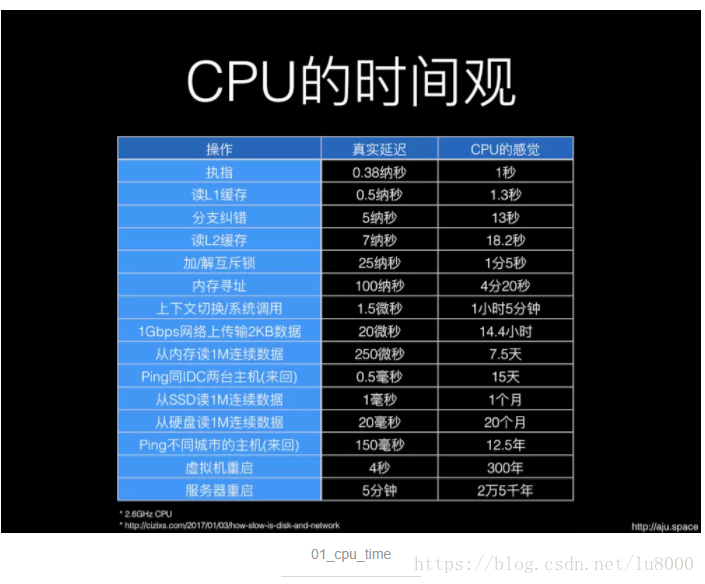

我们将一个 2.6GHz 的 CPU 拟人化，假设它执行一条命令的时间，他它感觉上过了一秒钟。CPU是计算机的处理核心，也是最宝贵的资源，如果有浪费CPU的运行时间，导致其利用率不足，那程序效率必然低下（因为实际上有资源可以使效率更高）。

如上图所示，`在千兆网上传输2KB数据，CPU感觉过了14个小时`，如果是在10M的公网上呢？那效率会低百倍！如果在这么长的一段时间内，CPU只是傻等结果而不能去干其他事情，是不是在浪费CPU的青春？

鲁迅说，浪费“CPU”的时间等于谋财害命。而凶手就是程序猿。

### 2.2 面临的问题
* 成本问题

如果一个程序不能有效利用一台计算机资源，那必然需要更多的计算机通过运行更多的程序实例来弥补需求缺口。例如我前不久主导重写的项目，使用Python异步编程，改版后由原来的7台服务器削减至3台，成本骤降57%。一台AWS m4.xlarge 型通用服务器按需付费实例一年价格约 1.2 万人民币。

* 效率问题

如果不在乎钱的消耗，那也会在意效率问题。当服务器数量堆叠到一定规模后，如果不改进软件架构和实现，加机器是徒劳，而且运维成本会骤然增加。比如别人家的电商平台支持6000单/秒支付，而自家在下单量才支撑2000单/秒，在双十一这种活动的时候，钱送上门也赚不到。

* C10k/C10M挑战

C10k（concurrently handling 10k connections）是一个在1999年被提出来的技术挑战，如何在一颗1GHz CPU，2G内存，1gbps网络环境下，让`单台服务器同时为1万个客户端提供FTP服务`。

而到了2010年后，随着硬件技术的发展，这个问题被延伸为C10M，即如何利用8核心CPU，64G内存，在10gbps的网络上保持1000万并发连接，`或是每秒钟处理100万的连接`。（两种类型的计算机资源在各自的时代都约为1200美元）

成本和效率问题是从企业经营角度讲，C10k/C10M问题则是从技术角度出发挑战软硬件极限。C10k/C10M 问题得解，成本问题和效率问题迎刃而解。

### 2.3 解决方案
《约束理论与企业优化》中指出：`“除了瓶颈之外，任何改进都是幻觉。”`

CPU告诉我们，它自己很快，而上下文切换慢、内存读数据慢、磁盘寻址与取数据慢、网络传输慢……总之，离开CPU 后的一切，除了一级高速缓存，都很慢。我们观察计算机的组成可以知道，主要由运算器、控制器、存储器、输入设备、输出设备五部分组成。运算器和控制器主要集成在CPU中，除此之外全是I/O，包括读写内存、读写磁盘、读写网卡全都是I/O。I/O成了最大的瓶颈。

异步程序可以提高效率，而最大的瓶颈在I/O，业界诞生的解决方案没出意料：异步I/O吧，异步I/O吧，异步I/O吧吧！


## 3 异步I/O进化之路
如今，地球上最发达、规模最庞大的计算机程序，莫过于因特网。而从CPU的时间观中可知，网络I/O是最大的I/O瓶颈，除了宕机没有比它更慢的。所以，诸多异步框架都对准的是网络I/O。

我们从一个爬虫例子说起，从因特网上下载10篇网页。

### 3.1 同步阻塞方式
最容易想到的解决方案就是依次下载，从建立socket连接到发送网络请求再到读取响应数据，顺序进行。


In [9]:
import time 
import socket

def http_get(url):
    sock = socket.socket()
    sock.connect((f"{url}", 80))
    req  = f"GET / HTTP/1.0\r\n{url}\r\n\r\n"
    resp = b""
    sock.send(req.encode())
    chunk = sock.recv(4096)
    while chunk:
        resp += chunk
        chunk = sock.recv(4096)
    return resp

def sync_get():
    r = list()
    for _ in range(10):
        r.append(http_get("example.com"))
    return r

if __name__ == "__main__":
    begin = time.time()
    print(sync_get()[-1])
    end = time.time()
    print(f"\nsync_get cast: {round(end-begin, 2)}S")

b'HTTP/1.0 400 Bad Request\r\nContent-Type: text/html\r\nContent-Length: 349\r\nConnection: close\r\nDate: Thu, 16 Jun 2022 10:40:56 GMT\r\nServer: ECSF (sab/56DF)\r\n\r\n<?xml version="1.0" encoding="iso-8859-1"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"\n         "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">\n\t<head>\n\t\t<title>400 - Bad Request</title>\n\t</head>\n\t<body>\n\t\t<h1>400 - Bad Request</h1>\n\t</body>\n</html>\n'

sync_get cast: 3.4S


* http_get() 的作用是建立 socket 连接
* 发送HTTP请求，然后从 socket读取HTTP响应并返回数据。
* 示例中我们请求了 example.com 的首页。在sync_way() 执行了10次，即下载 example.com 首页10次。


我们知道，创建网络连接，多久能创建完成不是客户端决定的，而是由网络状况和服务端处理能力共同决定。服务端什么时候返回了响应数据并被客户端接收到可供程序读取，也是不可预测的。
所以sock.connect()和sock.recv()这两个调用在默认情况下是`阻塞`的。

> 注：sock.send()函数并不会阻塞太久，它只负责将请求数据拷贝到TCP/IP协议栈的系统缓冲区中就返回，并不等待服务端返回的应答确认。

假设网络环境很差，创建网络连接需要1秒钟，那么sock.connect()就得阻塞1秒钟，等待网络连接成功。`这1秒钟对一颗2.6GHz的CPU来讲，仿佛过去了83年`，然而它不能干任何事情。sock.recv()也是一样的必须得等到服务端的响应数据已经被客户端接收。我们下载10篇网页，这个阻塞过程就得重复10次。如果一个爬虫系统每天要下载1000万篇网页呢？！


### 3.2 多进程方式

In [8]:
import time
import socket
from concurrent.futures import ProcessPoolExecutor
from functools import partial

def http_get1(url):
    sock = socket.socket()
    sock.connect((f"{url}", 80))
    req  = f"GET / HTTP/1.0\r\n{url}\r\n\r\n"
    resp = b""
    sock.send(req.encode())
    chunk = sock.recv(4096)
    while chunk:
        resp += chunk
        chunk = sock.recv(4096)
    return resp

def sync_get():
    futures = list()
    workers = 10
    executor = ProcessPoolExecutor(workers)
    task = partial(http_get1, "example.com")
    for _ in range(workers):
        futures.append(executor.submit(task))

    return [f.result() for f in futures]


if __name__ == "__main__":
    begin = time.time()
    print(sync_get()[-1])
    end = time.time()
    print(f"\nsync_get cast: {round(end-begin, 2)}S")

Exception in thread Thread-8:
Traceback (most recent call last):
  File "d:\tools\tools\python366-32with-pdb\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "d:\tools\tools\python366-32with-pdb\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "d:\tools\tools\python366-32with-pdb\lib\concurrent\futures\process.py", line 295, in _queue_management_worker
    shutdown_worker()
  File "d:\tools\tools\python366-32with-pdb\lib\concurrent\futures\process.py", line 253, in shutdown_worker
    call_queue.put_nowait(None)
  File "d:\tools\tools\python366-32with-pdb\lib\multiprocessing\queues.py", line 129, in put_nowait
    return self.put(obj, False)
  File "d:\tools\tools\python366-32with-pdb\lib\multiprocessing\queues.py", line 83, in put
    raise Full
queue.Full



BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

在python 里的多进程必须需要在入口出加入 `if ___name__ == "__main__" ` ，因为python 在子进程起来时候会重新加载代码导致递归创建自己子进程

* 报错是上面代码写错了, `futures.append(executor.submit(http_get))` 写错 `futures.append(executor.submit(sync_get))` 进程递归了，创建了很多进程
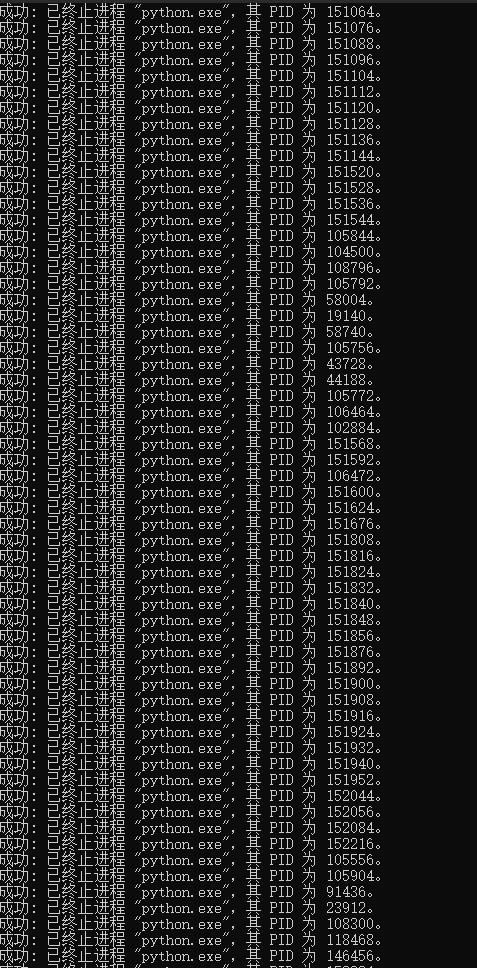

In [17]:
import os
os.system("python async_setps/demo2.py") # 输出的错误码

0

In [21]:
import subprocess 
result = subprocess.check_output(f"python {os.getcwd()}/async_setps/demo2.py")
print(result.decode())

b'HTTP/1.0 400 Bad Request\r\nContent-Type: text/html\r\nContent-Length: 349\r\nConnection: close\r\nDate: Thu, 16 Jun 2022 11:06:33 GMT\r\nServer: ECSF (sab/5772)\r\n\r\n<?xml version="1.0" encoding="iso-8859-1"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"\n         "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">\n\t<head>\n\t\t<title>400 - Bad Request</title>\n\t</head>\n\t<body>\n\t\t<h1>400 - Bad Request</h1>\n\t</body>\n</html>\n'

sync_get cast: 1.22S



进程切换开销不止像“CPU的时间观”所列的“上下文切换”那么低。CPU从一个进程切换到另一个进程，需要把旧进程运行时的寄存器状态、内存状态全部保存好，再将另一个进程之前保存的数据恢复。对CPU来讲，几个小时就干等着。当进程数量大于CPU核心数量时，进程切换是必然需要的。

除了切换开销，多进程还有另外的缺点。一般的服务器在能够稳定运行的前提下，可以同时处理的进程数在数十个到数百个规模。如果进程数量规模更大，系统运行将不稳定，而且可用内存资源往往也会不足。

多进程解决方案在面临每天需要成百上千万次下载任务的爬虫系统，或者需要同时搞定数万并发的电商系统来说，并不适合。

除了切换开销大，以及可支持的任务规模小之外，多进程还有其他缺点，如状态共享等问题，后文会有提及，此处不再细究。

### 3.3 多线程方式

In [7]:
import time 
import socket
from concurrent.futures import ThreadPoolExecutor

def http_get(url):
    sock = socket.socket()
    sock.connect((f"{url}", 80))
    req  = f"GET / HTTP/1.0\r\n{url}\r\n\r\n"
    resp = b""
    sock.send(req.encode())
    chunk = sock.recv(4096)
    while chunk:
        resp += chunk
        chunk = sock.recv(4096)
    return resp

def sync_get():
    futures = list()
    workers = 10
    executor = ThreadPoolExecutor(workers)
    task = partial(http_get1, "example.com")
    for _ in range(workers):
        futures.append(executor.submit(task))
    
    return [f.result() for f in futures]


if __name__ == "__main__":
    begin = time.time()
    print(sync_get()[-1])
    end = time.time()
    print(f"\nsync_get cast: {round(end-begin, 2)}S")

hell0
b'HTTP/1.0 400 Bad Request\r\nContent-Type: text/html\r\nContent-Length: 349\r\nConnection: close\r\nDate: Thu, 16 Jun 2022 10:40:14 GMT\r\nServer: ECSF (sab/56DF)\r\n\r\n<?xml version="1.0" encoding="iso-8859-1"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"\n         "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">\n\t<head>\n\t\t<title>400 - Bad Request</title>\n\t</head>\n\t<body>\n\t\t<h1>400 - Bad Request</h1>\n\t</body>\n</html>\n'

sync_get cast: 0.39S


#### 比对结果

* 同步： 3.4S
* 多线程：0.39S
* 多进程：1.07S

发现进程还有线程快，那是因为电脑里开的进程多了，切换进程需要额外成本，但是`异步就是比同步快`

* 但是
> 多线程仍有问题，特别是Python里的多线程。首先，Python中的多线程因为GIL的存在，它们并不能利用CPU多核优势，一个Python进程中，只允许有一个线程处于运行状态。那为什么结果还是如预期，耗时缩减到了十分之一？

因为在做阻塞的系统调用时，例如sock.connect(),sock.recv()时，当前线程会释放GIL，让别的线程有执行机会。但是单个线程内，在阻塞调用上还是阻塞的。

> 小提示：Python中 time.sleep 是阻塞的，都知道使用它要谨慎，但在多线程编程中，time.sleep 并不会阻塞其他线程。

除了GIL之外，所有的多线程还有通病。它们是被OS调度，调度策略是抢占式的，以保证同等优先级的线程都有均等的执行机会，那带来的问题是：并不知道下一时刻是哪个线程被运行，也不知道它正要执行的代码是什么。所以就可能存在竞态条件。

例如爬虫工作线程从任务队列拿待抓取URL的时候，如果多个爬虫线程同时来取，那这个任务到底该给谁？那就需要用到“锁”或“同步队列”来保证下载任务不会被重复执行。

而且线程支持的多任务规模，在数百到数千的数量规模。在大规模的高频网络交互系统中，仍然有些吃力。当然，多线程最主要的问题还是竞态条件。


## 3.4.非阻塞（回调）
### 3.4.1 epoll
判断非阻塞调用是否就绪如果 `OS` 能做，是不是应用程序就可以不用自己去等待和判断了，就可以利用这个空闲去做其他事情以提高效率。

所以OS将`I/O状态的变化`都封装成了事件，如可`读事件`、`可写事件`。并且提供了专门的系统模块让应用程序可以`接收事件通知`。这个模块就是`select`。让应用程序可以通过`select`注册文件描述符和回调函数。当文件描述符的状态发生变化时，`select 就调用事先注册的回调函数`。

select因其算法效率比较低，后来改进成了`poll`，再后来又有进一步改进，BSD内核改进成了`kqueue`模块，而Linux内核改进成了`epoll`模块。这四个模块的作用都相同，暴露给程序员使用的API也几乎一致，区别在于kqueue 和 epoll 在处理大量文件描述符时效率更高。

鉴于 Linux 服务器的普遍性，以及为了追求更高效率，所以我们常常听闻被探讨的模块都是` epoll` 。

### 3.4.2 回调(Callback)
把I/O事件的等待和监听任务交给了 OS，那 OS 在知道I/O状态发生改变后（例如socket连接已建立成功可发送数据），它又怎么知道接下来该干嘛呢？`只能回调`。

需要我们将发送数据与读取数据封装成独立的函数，让`epoll`代替应用程序监听`socket`状态时，得告诉epoll：“如果socket状态变为可以往里写数据（连接建立成功了），请调用HTTP请求发送函数。如果socket 变为可以读数据了（客户端已收到响应），请调用响应处理函数。”

于是我们利用epoll结合回调机制重构爬虫代码：
